<a href="https://colab.research.google.com/github/solayman-cs/ICH/blob/main/PhysioNet_Segmentation_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import imageio
import skimage.io
import skimage.transform
from pathlib import Path
from imageio import imread
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
%cd /content/drive/My Drive/DataSets/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0

/content/drive/My Drive/DataSets/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0


In [ ]:
os.listdir()

['LICENSE.txt',
 'README.txt',
 'split_data.py',
 'SHA256SUMS.txt',
 'hemorrhage_diagnosis.csv',
 'patient_demographics.csv',
 'ct_ich.yml',
 'Patients_CT',
 'mask_dir',
 'brain_image_dir',
 'model_cls.h5',
 'model.h5',
 'model_UNet_seg.h5',
 'model_seg_f.h5',
 'training_log.csv',
 'df_data.csv.gz',
 'df_val.csv.gz',
 'df_train.csv.gz',
 'df_test.csv.gz']

In [ ]:
diag_path = 'hemorrhage_diagnosis.csv'
df_diag = pd.read_csv(diag_path)
df_diag.shape

(2501, 9)

In [ ]:
def swap_target(x):
    if x == 0:
        return 1
    else:
        return 0

# create a new target column
df_diag['Has_Hemorrhage'] = df_diag['No_Hemorrhage'].apply(swap_target)

# drop the old target column
df_diag = df_diag.drop('No_Hemorrhage', axis=1)

print(df_diag.shape)

df_diag.head()

(2501, 9)


,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,Fracture_Yes_No,Has_Hemorrhage
0,49,1,0,0,0,0,0,0,0
1,49,2,0,0,0,0,0,0,0
2,49,3,0,0,0,0,0,0,0
3,49,4,0,0,0,0,0,0,0
4,49,5,0,0,0,0,0,0,0


In [ ]:
# Create new columns


def get_mask_fname(row):
        
    mask_id = str(row['SliceNumber']) + '_HGE_Seg.jpg'
    return mask_id
    

# create a new column with mask file names
df_diag['mask_fname'] = df_diag.apply(get_mask_fname, axis=1)




def new_mask_fname(row):
        
    mask_id = str(row['PatientNumber']) + '_' + str(row['SliceNumber']) + '_HGE_Seg.jpg'
    return mask_id


# create a new column with a new mask file names
df_diag['new_mask_fname'] = df_diag.apply(new_mask_fname, axis=1)




def assign_image_fname(row):
    
    image_fname = str(row['SliceNumber']) + '.jpg'
    
    return image_fname


# create a new column with image file names
df_diag['image_fname'] = df_diag.apply(assign_image_fname, axis=1)



def assign_new_fname(row):
         
    mask_id = str(row['PatientNumber']) + '_' + str(row['SliceNumber']) + '.jpg'
    
    return mask_id
    
# create a new column with new image file names
df_diag['new_image_fname'] = df_diag.apply(assign_new_fname, axis=1)



df_diag.head()

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,Fracture_Yes_No,Has_Hemorrhage,mask_fname,new_mask_fname,image_fname,new_image_fname
0,49,1,0,0,0,0,0,0,0,1_HGE_Seg.jpg,49_1_HGE_Seg.jpg,1.jpg,49_1.jpg
1,49,2,0,0,0,0,0,0,0,2_HGE_Seg.jpg,49_2_HGE_Seg.jpg,2.jpg,49_2.jpg
2,49,3,0,0,0,0,0,0,0,3_HGE_Seg.jpg,49_3_HGE_Seg.jpg,3.jpg,49_3.jpg
3,49,4,0,0,0,0,0,0,0,4_HGE_Seg.jpg,49_4_HGE_Seg.jpg,4.jpg,49_4.jpg
4,49,5,0,0,0,0,0,0,0,5_HGE_Seg.jpg,49_5_HGE_Seg.jpg,5.jpg,49_5.jpg


**Image Folder**

In [ ]:
path = 'Patients_CT'

folder_list = os.listdir(path)

len(folder_list)

82

In [ ]:
NUM_TEST_IMAGES = 100


# get 10 images without hemorrhages

df = df_diag[df_diag['Has_Hemorrhage'] == 0]

df_no_hem = df.sample(NUM_TEST_IMAGES, random_state=101)

# Reset the index.
df_no_hem = df_no_hem.reset_index(drop=True)

# create a list of images
test_images_list = list(df_no_hem['new_mask_fname'])


# Select only rows that are not part of the test set.
# Note the use of ~ to execute 'not in'.
df_diag = df_diag[~df_diag['new_mask_fname'].isin(test_images_list)]


# get 10 images with hemorrhages

df = df_diag[df_diag['Has_Hemorrhage'] == 1]

df_with_hem = df.sample(NUM_TEST_IMAGES, random_state=102)

# Reset the index.
df_with_hem = df_with_hem.reset_index(drop=True)

# create a list of images
test_images_list = list(df_with_hem['new_mask_fname'])


# Select only rows that are not part of the test set.
# Note the use of ~ to execute 'not in'.
df_diag = df_diag[~df_diag['new_mask_fname'].isin(test_images_list)]


# create the test set
df_test = pd.concat([df_with_hem, df_no_hem], axis=0).reset_index(drop=True)

In [ ]:
print(df_diag.shape)
print(df_test.shape)

(2301, 13)
(200, 13)


In [ ]:
# train_test_split


# shuffle
df_diag = shuffle(df_diag)

# reset the index
df_diag = df_diag.reset_index(drop=True)

# We will stratify by target
y = df_diag['Has_Hemorrhage']

df_train, df_val = train_test_split(df_diag, test_size=0.15, random_state=107, stratify=y)

print(df_train.shape)
print(df_val.shape)

(1955, 13)
(346, 13)


In [ ]:
df_diag.to_csv('df_data.csv.gz', compression='gzip', index=False)

df_train.to_csv('df_train.csv.gz', compression='gzip', index=False)
df_val.to_csv('df_val.csv.gz', compression='gzip', index=False)

df_test.to_csv('df_test.csv.gz', compression='gzip', index=False)

In [ ]:
# Function to perform the augmentations

def augment_image_and_mask(augmentation, image, mask):
    
    """
 
    Uses the Albumentations library.
    
    Inputs: 
    1. augmentation - this is the instance of type of augmentation to do 
    e.g. aug_type = HorizontalFlip(p=1) 
    # p=1 is the probability of the transform being executed.
    
    2. image - image with shape (h,w)
    3. mask - mask with shape (h,w)
    
    Output:
    Augmented image as a numpy array.
    Augmented mask as a numpy array.
    
    """
    # get the transform as a dict
    aug_image_dict =  augmentation(image=image, mask=mask)
    # retrieve the augmented matrix of the image
    image_matrix = aug_image_dict['image']
    
    mask_matrix = aug_image_dict['mask']
    
    return image_matrix, mask_matrix

In [ ]:
# HOW TO DO MULTIPLE AUGMENTATIONS

import albumentations as albu

# Define the augmentations

aug_types = albu.Compose([
    albu.HorizontalFlip(p=0.5),
    albu.OneOf([
        albu.RandomContrast(),
        albu.RandomGamma(),
        albu.RandomBrightness(),
        ], p=0.3),
    albu.OneOf([
        albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        albu.GridDistortion(),
        albu.OpticalDistortion(distort_limit=2, shift_limit=0.5),
        ], p=0.3),
    albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=10, shift_limit=0.1, p=0.5, border_mode=0),
])


In [ ]:
IMAGE_HEIGHT_ORIG = 650
IMAGE_WIDTH_ORIG = 650

NUM_TEST_IMAGES = 10 # 10 with intracranial hem + 10 without intracranial hem

IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
IMAGE_CHANNELS = 3

BATCH_SIZE = 10

In [ ]:
df_train.head(10)

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,Fracture_Yes_No,Has_Hemorrhage,mask_fname,new_mask_fname,image_fname,new_image_fname
189,101,28,0,0,0,0,0,0,0,28_HGE_Seg.jpg,101_28_HGE_Seg.jpg,28.jpg,101_28.jpg
807,68,26,0,0,0,0,0,1,0,26_HGE_Seg.jpg,68_26_HGE_Seg.jpg,26.jpg,68_26.jpg
2036,125,38,0,0,0,0,0,0,0,38_HGE_Seg.jpg,125_38_HGE_Seg.jpg,38.jpg,125_38.jpg
1969,129,30,0,0,0,0,0,0,0,30_HGE_Seg.jpg,129_30_HGE_Seg.jpg,30.jpg,129_30.jpg
1544,82,5,0,0,0,0,0,0,0,5_HGE_Seg.jpg,82_5_HGE_Seg.jpg,5.jpg,82_5.jpg
37,129,17,0,0,0,0,0,0,0,17_HGE_Seg.jpg,129_17_HGE_Seg.jpg,17.jpg,129_17.jpg
314,129,28,0,0,0,0,0,0,0,28_HGE_Seg.jpg,129_28_HGE_Seg.jpg,28.jpg,129_28.jpg
361,127,21,0,0,0,0,0,0,0,21_HGE_Seg.jpg,127_21_HGE_Seg.jpg,21.jpg,127_21.jpg
1496,129,19,0,0,0,0,0,0,0,19_HGE_Seg.jpg,129_19_HGE_Seg.jpg,19.jpg,129_19.jpg
962,128,9,0,0,0,0,0,0,0,9_HGE_Seg.jpg,128_9_HGE_Seg.jpg,9.jpg,128_9.jpg


In [ ]:
# We are only using brain images for training.
# These are originally single channel images but cv2 will read them with 3 channels.

import cv2

def train_generator(batch_size=10):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_train.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['new_image_fname'])
            mask_id_list = list(df['new_mask_fname'])
            #lbl_list = list(df['Has_Hemorrhage'])
            
            labels = np.zeros(len(df), dtype=np.uint8)
            # Create empty X matrix - 3 channels
            X_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            
            # create empty Y matrix - 1 channel
            #Y_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.bool)
            Y_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.float32)

        
            
            # Create X_train
            #================
            
            for i in range(0, len(image_id_list)):
              
              
                # get the image and mask
                image_id = image_id_list[i]
                mask_id = mask_id_list[i]
                #lbl = lbl_list[i]

                # set the path to the image
                path = 'brain_image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                
            
            
            # Create Y_train
            # ===============
                
 

                # set the path to the mask
                path = 'mask_dir/' + mask_id

                # read the mask
                mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)
                
                # resize the mask
                mask = cv2.resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                # expand dims from (800,600) to (800,600,1)
                mask = np.expand_dims(mask, axis=-1)
         
                
                
              
              
              
            # Augment the image and mask
            # ===========================
            
                aug_image, aug_mask = augment_image_and_mask(aug_types, image, mask)
              
                # insert the image into X_train
                X_train[i] = aug_image
                
                # insert the image into Y_train
                Y_train[i] = aug_mask

                #labels[i] = lbl
                
                              
                
            # Normalize the images
            X_train = X_train/255
            Y_train = Y_train/255
            #labels = np.asarray(labels).astype('float32').reshape((-1,1))
            #labels = tf.one_hot(labels, depth=2)

            yield X_train, Y_train

In [ ]:
# Test the generator

# initialize
train_gen = train_generator(batch_size=10)
print(train_gen)

# run the generator
X_train, Y_train = next(train_gen)

print(len(X_train))

print(X_train.shape)
print(Y_train.shape)
#print(labels.shape)

<generator object train_generator at 0x7fb0e2294d50>
10
(10, 256, 256, 3)
(10, 256, 256, 1)


In [ ]:
def val_generator(batch_size=10):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_val.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['new_image_fname'])
            mask_id_list = list(df['new_mask_fname'])
            #lbl_list = list(df['Has_Hemorrhage'])
            
            val_labels = np.zeros(len(df), dtype=np.uint8)
            # Create empty X matrix - 3 channels
            X_val = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            
            # create empty Y matrix - 1 channel
            Y_val = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.float32)

        
            
            # Create X_val
            #================
            
            for i, image_id in enumerate(image_id_list):
                

                # set the path to the image
                path = 'brain_image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                # insert the image into X_train
                X_val[i] = image
                #lbl = lbl_list[i]
            
            
            # Create Y_val
            # ===============
                
            for j, mask_id in enumerate(mask_id_list):

                # set the path to the mask
                path = 'mask_dir/' + mask_id

                # read the mask
                mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)
                
                # resize the mask
                mask = cv2.resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                # expand dims from (800,600) to (800,600,1)
                mask = np.expand_dims(mask, axis=-1)
                
                
                
                
                # insert the image into Y_train
                Y_val[j] = mask
                #val_labels[j] = lbl
                
            
            # Normalize the images
            X_val = X_val/255
            Y_val = Y_val/255
            #val_labels = np.asarray(val_labels).astype('float32').reshape((-1,1))
            
            yield X_val, Y_val

In [ ]:
# Test the generator

# initialize
val_gen = val_generator(batch_size=10)

# run the generator
X_val, Y_val = next(val_gen)

print(X_val.shape)
print(Y_val.shape)
#print(val_labels.shape)

(10, 256, 256, 3)
(10, 256, 256, 1)


In [ ]:
def test_generator(batch_size=1):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_test.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['new_image_fname'])
            mask_id_list = list(df['new_mask_fname'])
            
            # Create empty X matrix - 3 channels
            X_test = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            
            # create empty Y matrix - 1 channel
            #Y_test = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.bool)
            Y_test = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.float32)
            
            


            
            # Create X_test
            #================
            
            for i, image_id in enumerate(image_id_list):
                

                # set the path to the image
                path = 'brain_image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
           
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                # insert the image into X_train
                X_test[i] = image
                
             
            # Create Y_test
            # ===============
                
            for j, mask_id in enumerate(mask_id_list):

                # set the path to the mask
                path = 'mask_dir/' + mask_id

                # read the mask
                mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)
                
                # resize the mask
                mask = cv2.resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                # expand dims from (800,600) to (800,600,1)
                mask = np.expand_dims(mask, axis=-1)
                
                
                
                
                # insert the image into Y_train
                Y_test[j] = mask
            
            #tf.cast(Y_test, tf.float32)
            # Normalize the images
            X_test = X_test/255
            Y_test = Y_test/255
            
            yield X_test, Y_test

In [ ]:
# Test the generator

# initialize
test_gen = test_generator(batch_size=15)

# run the generator
X_test, Y_test = next(test_gen)

print(X_test.shape)
print(Y_test.shape)

(15, 256, 256, 3)
(15, 256, 256, 1)


In [ ]:
!pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.2 MB/s 


In [ ]:
from keras.models import Model, load_model
from keras.layers import Input, UpSampling2D
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

from keras.callbacks import (EarlyStopping, ReduceLROnPlateau, 
                                        ModelCheckpoint, CSVLogger, LearningRateScheduler)

import tensorflow as tf

from tensorflow.keras.optimizers import Adam

from keras.losses import binary_crossentropy

from keras.initializers import he_normal 

In [ ]:
import segmentation_models as sm
from segmentation_models import Unet, FPN
from segmentation_models import  get_preprocessing # this line has an error in the docs

from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

from segmentation_models.losses import dice_loss
#from segmentation_models.metrics import dice_score

from segmentation_models.utils import set_trainable

sm.set_framework('tf.keras')

sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [ ]:
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = BATCH_SIZE
val_batch_size = BATCH_SIZE

# determine numtrain steps
train_steps = np.ceil(num_train_samples / train_batch_size)
# determine num val steps
val_steps = np.ceil(num_val_samples / val_batch_size)

In [ ]:
#preprocess = get_preprocessing('resnet101') # for resnet, img = (img-110.0)/1.0

# 'efficientnetb0'

BACKBONE = 'mobilenetv2'
preprocess_input = get_preprocessing(BACKBONE)

# Note that the model takes 3-channel images as input
model = Unet(BACKBONE, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), 
             #freeze_encoder=False,
             classes=1, 
             encoder_weights='imagenet',
             activation='sigmoid')

#model.summary()

/usr/local/lib/python3.7/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# Initialize the generators
train_gen = train_generator(batch_size=BATCH_SIZE)
val_gen = val_generator(batch_size=BATCH_SIZE)

#The U-Net model
#This code was original downloaded from https://github.com/zhixuhao/unet, then edited
def jaccard_loss(y_true, y_pred): #https://www.jeremyjordan.me/evaluating-image-segmentation-models/
    intersection = y_true*y_pred
    union = 1 -((1-y_true)*(1-y_pred))
    return 1-(K.sum(intersection) / K.sum(union))

model.compile(
    Adam(learning_rate=0.0001),
    loss=dice_loss,
    #loss=bce_jaccard_loss,
    metrics=[iou_score],
)


filepath = "model_seg_f.h5"

earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, 
                                   verbose=1, mode='min')


log_fname = 'training_log.csv'
csv_logger = CSVLogger(filename=log_fname,
                       separator=',',
                       append=False)

callbacks_list = [checkpoint, earlystopper, csv_logger, reduce_lr]
history = model.fit(train_gen, steps_per_epoch=train_steps, epochs=200, 
                              validation_data=val_gen, validation_steps=val_steps,
                              verbose=1,
                              callbacks=callbacks_list)

Epoch 1/200
196/196 [==============================] - ETA: 0s - loss: 0.9951 - iou_score: 0.0025
Epoch 1: val_loss improved from inf to 0.99821, saving model to model_seg_f.h5
196/196 [==============================] - 875s 4s/step - loss: 0.9951 - iou_score: 0.0025 - val_loss: 0.9982 - val_iou_score: 8.8863e-04 - lr: 1.0000e-04
Epoch 2/200
196/196 [==============================] - ETA: 0s - loss: 0.9893 - iou_score: 0.0055
Epoch 2: val_loss improved from 0.99821 to 0.99377, saving model to model_seg_f.h5
196/196 [==============================] - 45s 232ms/step - loss: 0.9893 - iou_score: 0.0055 - val_loss: 0.9938 - val_iou_score: 0.0031 - lr: 1.0000e-04
Epoch 3/200
196/196 [==============================] - ETA: 0s - loss: 0.9742 - iou_score: 0.0137
Epoch 3: val_loss did not improve from 0.99377
196/196 [==============================] - 42s 216ms/step - loss: 0.9742 - iou_score: 0.0137 - val_loss: 0.9984 - val_iou_score: 7.9275e-04 - lr: 1.0000e-04
Epoch 4/200
196/196 [===========

In [ ]:
# Make a prediction

# initialize the test generator
test_gen = test_generator(batch_size=1)

model.load_weights('model_seg_f.h5')
predictions = model.predict_generator(test_gen, 
                                      steps=len(df_test),  
                                      verbose=1)

NameError: ignored

In [ ]:
preds_test_thresh = (predictions >= 0.7).astype(np.uint8)

preds_test_thresh.shape

print(preds_test_thresh.min())
print(preds_test_thresh.max())

NameError: ignored

In [ ]:
indx = 4

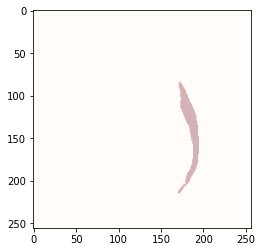

In [ ]:
# This is a predicted mask

mask = preds_test_thresh[indx,:,:,0]
plt.imshow(mask, cmap='Reds', alpha=0.3)

In [ ]:
# This is a true mask

true_mask = Y_test[indx,:,:,0]
plt.imshow(true_mask, cmap='Blues', alpha=0.3)

IndexError: ignored

In [ ]:
def iou_scr (mask, true_mask):
  intersection = np.logical_and(mask, true_mask)
  union = np.logical_or(mask, true_mask)
  iou_score = np.sum(intersection) / np.sum(union)
  return iou_score


In [ ]:
res = iou_scr(mask, true_mask)
print(res)

0.24296296296296296


In [ ]:
mn_iou = []
y = 10
for indx in range(y):
  pred = preds_test_thresh[indx,:,:,0]
  true = Y_test[indx,:,:,0]
  r = iou_scr(pred, true)
  mn_iou.append(r)



In [ ]:
print(mn_iou)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006802721088435374, 0.0, 0.0, 0.023529411764705882]


In [ ]:
for i in mn_iou:
  res = sum(mn_iou)/y

print(res) 

0.0030332132853141255


In [ ]:
intersection = np.logical_and(mask, true_mask)
union = np.logical_or(mask, true_mask)
iou_score = np.sum(intersection) / np.sum(union)
print('IoU is %s' % iou_score)

IoU is 0.015182186234817813


In [ ]:
%cd /content/drive/My Drive/NoteBooks/DWT-ICH

/content/drive/My Drive/NoteBooks/DWT-ICH


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# import the dwt_ich library
from  dwt_ich import ICH

In [ ]:
#create object of ICH class
brain = ICH()

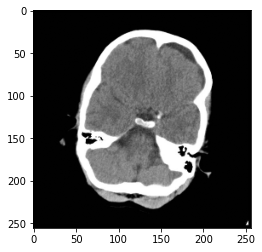

In [ ]:
img = X_test[4,:,:,:]
plt.imshow(img)
plt.savefig('foo.png')

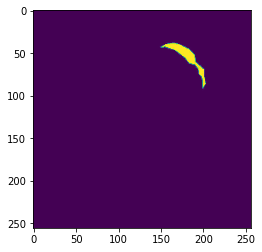

In [ ]:
img1 = Y_test[4,:,:,0]
plt.imshow(img1)

In [ ]:
# call the predict method and pass the image path
x = 'foo.png'
res, pred_mask = brain.predict(x)

**DWT**

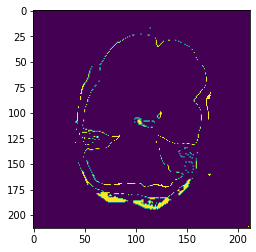

In [ ]:
plt.imshow(pred_mask)

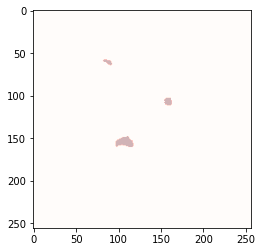

In [ ]:
# This is a predicted mask

mask = preds_test_thresh[14,:,:,0]
plt.imshow(mask, cmap='Reds', alpha=0.3)

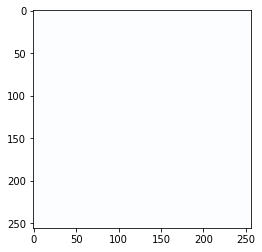

In [ ]:
# This is a true mask

true_mask = Y_test[14,:,:,0]
plt.imshow(true_mask, cmap='Blues', alpha=0.3)

In [ ]:
intersection = np.logical_and(mask, true_mask)
union = np.logical_or(mask, true_mask)
iou_score = np.sum(intersection) / np.sum(union)
print('IoU is %s' % iou_score)

IoU is 0.0


In [ ]:
def Jaccard_img(y_true, y_pred): #https://www.jeremyjordan.me/evaluating-image-segmentation-models/
    iou_score=0
    counter=0
    for i in range(y_true.shape[0]):
        if np.sum(y_true[i])>0:#Considering only the slices that have hemorrhage regions, if y_true is all zeros -> iou_score=nan.
            im1 = np.asarray(y_true[i]).astype(np.bool)
            im2 = np.asarray(y_pred[i]).astype(np.bool)
            intersection = np.logical_and(im1, im2)
            union = np.logical_or(im1, im2)
            iou_score+= np.sum(intersection) / np.sum(union)
            counter+=1
    if counter>0:
        return iou_score/counter
    else:
        return np.nan

In [ ]:
jac_indx = Jaccard_img(mask, pred_mask)
print(jac_indx)
print('*_--------------------------------------------')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


ValueError: ignored